# Analyze A/B Test Results  

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I am working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

## Part I - Probability


In [38]:
#To get started, let's import our libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
# read the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# number of rows and columns
df.shape

(294478, 5)

In [5]:
# number of unique users
df.user_id.nunique()

290584

In [7]:
# measure the proportion of users converted
df.converted.mean()

0.11965919355605512

In [8]:
# total items of (treatment group with old page) and (not treatment group with new page)
df_treatment = df.query('group == "treatment" & landing_page != "new_page"')
df_new_page = df.query('group != "treatment" & landing_page == "new_page"')
df_treatment.shape[0] + df_new_page.shape[0]

3893

In [9]:
# null values in each column
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df1 = df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)
df2 = df1.drop(df1[(df['group'] == 'control') & (df1['landing_page'] != 'old_page')].index)

C:\Users\power\AppData\Local\Temp/ipykernel_2904/1468648646.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df['group'] == 'control') & (df1['landing_page'] != 'old_page')].index)


In [12]:
# Double Check all of the incorrect rows were removed from df2
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
# number of unique users in the new dataframe f2
df2.user_id.nunique()

290584

In [14]:
# number of duplicate users in the new dataframe f2
df2.user_id.duplicated().sum()

1

In [15]:
# exploring the duplicate user
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [16]:
# Removing the row with a duplicate user_id..
df2.drop(index=2893, inplace=True)
# Checking again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


**a.** What is the probability of an individual converting regardless of the page they receive?

In [17]:
# measure the proportion of users converted
p_population = (df['converted'] == 1).mean()
p_population

0.11965919355605512

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# measure the converted rate the control group
cov_ctr = df2.query('group == "control"').converted.mean()
cov_ctr

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# measure the converted rate the treatment group
cov_tr = df2.query('group == "treatment"').converted.mean()
cov_tr

0.11880806551510564

In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups
obs_diff = cov_tr - cov_ctr
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [21]:
# the probability that an individual received the new page
df2.query('landing_page == "new_page"').shape[0] / df2.landing_page.shape[0]

0.5000619442226688

>**The conversion rate of the new group (treatment) is about 0.1188 which is less than the conversion rate of the old group (control) that has 12 conversion rate. So the new group users didn't lead to more conversions**. 

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general. 

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  


>**H0: p_new <= p_old**
   
>**H1: p_new > p_old**

Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
# conversion rate of the new page under the null hypothesis
p_new = p_population
p_new

0.11965919355605512

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis?

In [23]:
# conversion rate of the old page under the null hypothesis
p_old = p_population
p_old

0.11965919355605512

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [24]:
# number of users that are shown the new page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?


In [25]:
# number of users that are shown the old page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1 - p_new]).mean()
new_page_converted

0.8790241552542839

In [27]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1 - p_old]).mean()
old_page_converted

0.8805292068780374

In [28]:
# the difference between the two simulated samples
new_page_converted - old_page_converted

-0.0015050516237534728

In [29]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1 - p_old]).mean()
    new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1 - p_new]).mean()
    p_diffs.append(old_page_converted - new_page_converted)

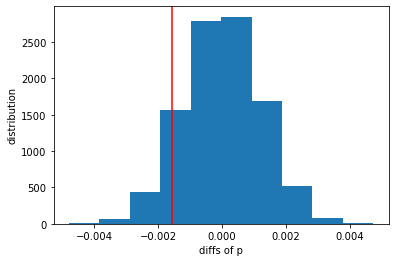

In [30]:
# convert p_diffs to numpy array
p_diffs = np.array(p_diffs)
# plotting the sampling distribution
plt.hist(p_diffs)
plt.xlabel('diffs of p')
plt.ylabel('distribution')
plt.axvline(obs_diff, c='r')

**e.**What proportion of the p_diffs are greater than the actual difference observed in the df2 data?

In [31]:
(p_diffs > obs_diff).mean()

0.9075

>**In the above cell, I am computing the p value which expresses if the simulated difference between the old & new groups is greater than the actual difference between the old & new groups.
p value is much larger than Type 1 error which means that we fail to reject H0, so the old page has the same conversion rate as the new page or maybe better.**


**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page

In [34]:
# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


>**Since Z_score for our test (right-tailed test) is smaller than Z_0.05 so we cannot reject H0.**

<a id='regression'></a>
### Part III - A regression approach

Since each row in the df2 data is either a conversion or no conversion with 1 or 0 values respectively, So we will use the logistic regression.

**a.** The goal is to use **statsmodels** library to fit the regression model to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
df2[['control','ab_page']]= pd.get_dummies(df2['group'])
df2.head(10)

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1


In [37]:
df2 = df2.drop(['control'], axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [41]:
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:               8.077e-06
Time:                        21:26:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

>**The p-value of ab_page is 0.19. It is higher than 0.05. So the coefficient is not significant.**

>**Alternative hypothesis associated with part II: the conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one_tailed test. In Part III, the alternative hypothesis can be formulated as follows:
(1) The landing_page type influences (positively or negatively) the conversion rate or
(2) the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.**

>**The p_value is very different. In part II, the p_value is 0.9026. This might happen because the tests of the regression model assumes an intercept and because of differences in one or two_tailed testing.**

**b.** Now, we are considering other things that might influence whether or not an individual converts.
It is a good idea to consider other factors in order to identify other potential influences on the conversion rate.
The disadvantage is that the model gets more complex.

**c. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also we add an effect based on which country a user lives in. 

1. we need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows, and call the resulting dataframe `df_new`. 

2. Does it appear that country had an impact on conversion?  To answer this question, we consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. we Create dummy variables for these country columns. 



In [42]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')

In [43]:
# Join with the df2 dataframe
df_new = df2.merge(df_countries, on='user_id')
df_new.head(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0,1,US
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [44]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [45]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [46]:
df_new['intercept'] = 1
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:               2.323e-05
Time:                        21:32:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

>**p values for the two countries (CA, US) are above the type 1 error.**

**d.**Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.

In [47]:
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_ab_page'] = df_new['CA'] * df_new['ab_page']
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,US_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [48]:
# Fit our model, and summarize the results
df_new['intercept'] = 1
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','US','US_ab_page','CA','CA_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:               3.482e-05
Time:                        21:37:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

>**p values of all dumies variable are above the type 1 error which means that we fail to reject H0.**

>**There is not strong evidence that the countries (US, CA, UK) affect on the conversion rate.**

>**Overall, there is not evidence that the new_page increases the conversion rate compared to the old_page according to the probability, A/B test and the regression.**